In [1]:
from sklearn.datasets import fetch_openml

# MNIST Classification

## MNIST

In [2]:
mnist = fetch_openml('mnist_784', as_frame=False)

/Users/robbieardison/anaconda3/envs/tf-pro/lib/python3.11/site-packages/sklearn/datasets/_openml.py:1022: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


In [3]:
X, y = mnist.data, mnist.target
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

In [7]:
import matplotlib.pyplot as plt

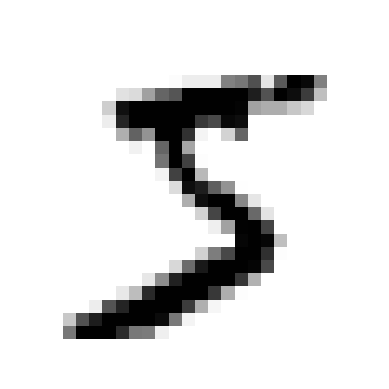

In [8]:
def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

some_digit = X[0]
plot_digit(some_digit)
plt.show()

In [9]:
y[0]

'5'

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

Let’s simplify the problem for now and only try to identify one digit—for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and non-5. First we’ll create the target vectors for this classification task:

In [11]:
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [12]:
from sklearn.linear_model import SGDClassifier

In [13]:
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

## Performance Measures

### Measuring Accuracy Using Cross-Validation

In [15]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Wow! Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a dummy classifier that just classifies every single image in the most frequent class, which in this case is the negative class (i.e., non 5):

In [16]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier()
dummy_clf.fit(X_train, y_train_5)
print(any(dummy_clf.predict(X_train)))

False


In [17]:
cross_val_score(dummy_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

That’s right, it has over 90% accuracy! This is simply because only about 10% of the images are 5s, so if you always guess that an image is not a 5, you will be right about 90% of the time. Beats Nostradamus.
This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent than others). A much better way to evaluate the performance of a classifier is to look at the confusion matrix (CM).

Implementing Cross-Validation
Occasionally you will need more control over the cross-validation process than what Scikit-Learn provides off the shelf. In these cases, you can implement cross- validation yourself. The following code does roughly the same thing as Scikit-Learn’s cross_val_score() function, and it prints the same result:

### Implementing Cross-Validation

In [18]:
from sklearn.model_selection import StratifiedKFold 
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3) # add shuffle=True if the dataset is # not already shuffled

for train_index, test_index in skfolds.split(X_train, y_train_5): 
      clone_clf = clone(sgd_clf)
      X_train_folds = X_train[train_index]
      y_train_folds = y_train_5[train_index]
      X_test_fold = X_train[test_index]
      y_test_fold = y_train_5[test_index]
      clone_clf.fit(X_train_folds, y_train_folds)
      y_pred = clone_clf.predict(X_test_fold)
      n_correct = sum(y_pred == y_test_fold)
      print(n_correct / len(y_pred)) # prints 0.95035, 0.96035, and 0.9604

0.95035
0.96035
0.9604


### Confusion Matrices

The general idea of a confusion matrix is to count the number of times instances of class A are classified as class B, for all A/B pairs. For example, to know the number of times the classifier confused images of 8s with 0s, you would look at row #8, column #0 of the confusion matrix.

To compute the confusion matrix, you first need to have a set of predictions so that they can be compared to the actual targets. You could make predictions on the test set, but it’s best to keep that untouched for now (remember that you want to use the test set only at the very end of your project, once you have a classifier that you are ready to launch). Instead, you can use the cross_val_predict() function:

In [19]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [20]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_train_5, y_train_pred)
cm

array([[53892,   687],
       [ 1891,  3530]])

Each row in a confusion matrix represents an actual class, while each column rep‐ resents a predicted class. The first row of this matrix considers non-5 images (the negative class): 53,892 of them were correctly classified as non-5s (they are called true negatives), while the remaining 687 were wrongly classified as 5s (false positives, also called type I errors). The second row considers the images of 5s (the positive class): 1,891 were wrongly classified as non-5s (false negatives, also called type II errors), while the remaining 3,530 were correctly classified as 5s (true positives). A perfect classifier would only have true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right):

In [21]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### Precision and Recall

In [22]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred) # == 3530 / (687 + 3530)

0.8370879772350012

In [23]:
recall_score(y_train_5, y_train_pred) # == 3530 / (1891 + 3530)

0.6511713705958311

Now our 5-detector does not look as shiny as it did when we looked at its accuracy. When it claims an image represents a 5, it is correct only 83.7% of the time. More‐ over, it only detects 65.1% of the 5s.

It is often convenient to combine precision and recall into a single metric called the F1 score, especially when you need a single metric to compare two classifiers. The F1 score is the harmonic mean of precision and recall (Equation 3-3). Whereas the regular mean treats all values equally, the harmonic mean gives much more weight to low values. As a result, the classifier will only get a high F1 score if both recall and precision are high.

To compute the F1 score, simply call the f1_score() function:

In [24]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

The F1 score favors classifiers that have similar precision and recall. This is not always what you want: in some contexts you mostly care about precision, and in other contexts you really care about recall. For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). On the other hand, suppose you train a classifier to detect shoplifters in surveillance images: it is probably fine if your classifier only has 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).
Unfortunately, you can’t have it both ways: increasing precision reduces recall, and vice versa. This is called the precision/recall trade-off.

### The Precision/Recall Trade-off

To understand this trade-off, let’s look at how the SGDClassifier makes its classification decisions. For each instance, it computes a score based on a decision function. If that score is greater than a threshold, it assigns the instance to the positive class; otherwise it assigns it to the negative class. Conversely, lowering the threshold increases recall and reduces precision.

Scikit-Learn does not let you set the threshold directly, but it does give you access to the decision scores that it uses to make predictions. Instead of calling the classifier’s predict() method, you can call its decision_function() method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores:

In [25]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [26]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

The SGDClassifier uses a threshold equal to 0, so the preceding code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

In [27]:
threshold = 3000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

This confirms that raising the threshold decreases recall. The image actually repre‐ sents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 3,000.

How do you decide which threshold to use? First, use the cross_val_predict() function to get the scores of all instances in the training set, but this time specify that you want to return decision scores instead of predictions:



In [28]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                                 method="decision_function")

With these scores, use the precision_recall_curve() function to compute precision and recall for all possible thresholds (the function adds a last precision of 0 and a last recall of 1, corresponding to an infinite threshold):

In [29]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Use Matplotlib to plot precision and recall as functions of the threshold value. Let’s show the threshold of 3,000 we selected:

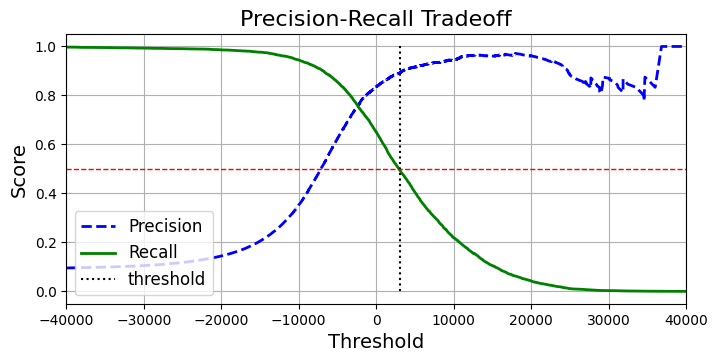

In [30]:
fig, ax = plt.subplots(figsize=(8, 3.5))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2) 
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2) 
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

plt.xlabel("Threshold", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Precision-Recall Tradeoff", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)
plt.axhline(y=0.5, color='r', linestyle='--', linewidth=1, label="Decision Boundary")

# Adjust x-axis scale
plt.xlim(-40000, 40000)

plt.show()

At this threshold value, precision is near 90% and recall is around 50%. Another way to select a good precision/recall trade-off is to plot precision directly against recall (the same threshold is shown):

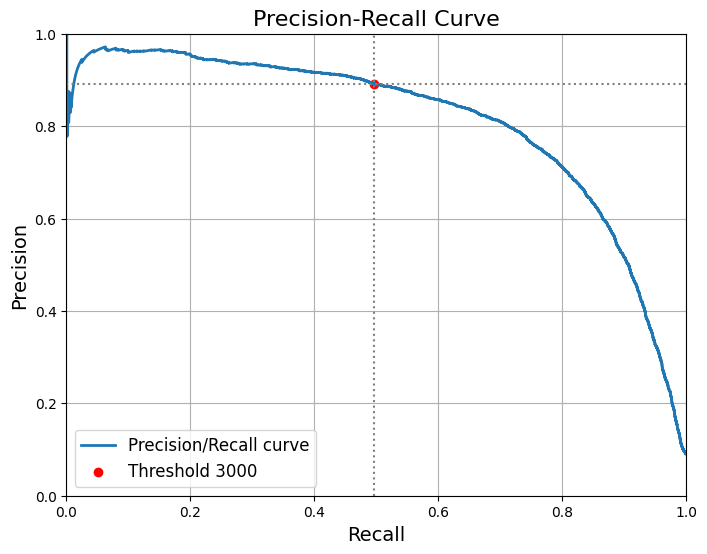

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Create a figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the Precision-Recall curve
plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

# Highlight the point at threshold (3000)
threshold_highlight = 3000
highlight_index = np.argmax(thresholds >= threshold_highlight)

plt.scatter(recalls[highlight_index], precisions[highlight_index], color='red', marker='o', label=f'Threshold {threshold_highlight}')

# Add dotted lines from the point to the x-axis
plt.axvline(x=recalls[highlight_index], linestyle='dotted', color='gray')
plt.axhline(y=precisions[highlight_index], linestyle='dotted', color='gray')

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

# Beautify the figure
plt.xlabel("Recall", fontsize=14)
plt.ylabel("Precision", fontsize=14)
plt.title("Precision-Recall Curve", fontsize=16)
plt.legend(loc="lower left", fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


You can see that precision really starts to fall sharply at around 80% recall. You will probably want to select a precision/recall trade-off just before that drop—for example, at around 60% recall. But of course, the choice depends on your project.
Suppose you decide to aim for 90% precision. You could use the first plot to find the threshold you need to use, but that’s not very precise. Alternatively, you can search for the lowest threshold that gives you at least 90% precision. For this, you can use the NumPy array’s argmax() method. This returns the first index of the maximum value, which in this case means the first True value:

In [32]:
idx_for_90_precision = (precisions >= 0.90).argmax()
threshold_for_90_precision = thresholds[idx_for_90_precision] 
threshold_for_90_precision

3370.0194991439566

To make predictions (on the training set for now), instead of calling the classifier’s predict() method, you can run this code:

In [33]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [34]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [35]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)
recall_at_90_precision

0.4799852425751706

Great, you have a 90% precision classifier! As you can see, it is fairly easy to create a classifier with virtually any precision you want: just set a high enough threshold, and you’re done. But wait, not so fast–a high-precision classifier is not very useful if its recall is too low! For many applications, 48% recall wouldn’t be great at all.

If someone says, “Let’s reach 99% precision”, you should ask, “At what recall?”

### The ROC Curve

The receiver operating characteristic (ROC) curve is another common tool used with binary classifiers. It is very similar to the precision/recall curve, but instead of plot‐ ting precision versus recall, the ROC curve plots the true positive rate (another name for recall) against the false positive rate (FPR). The FPR (also called the fall-out) is the ratio of negative instances that are incorrectly classified as positive. It is equal to 1 – the true negative rate (TNR), which is the ratio of negative instances that are correctly classified as negative. The TNR is also called specificity. Hence, the ROC curve plots sensitivity (recall) versus 1 – specificity.

To plot the ROC curve, you first use the roc_curve() function to compute the TPR and FPR for various threshold values:

In [36]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib. To find the point that corresponds to 90% precision, we need to look for the index of the desired threshold. Since thresholds are listed in decreasing order in this case, we use <= instead of >= on the first line:

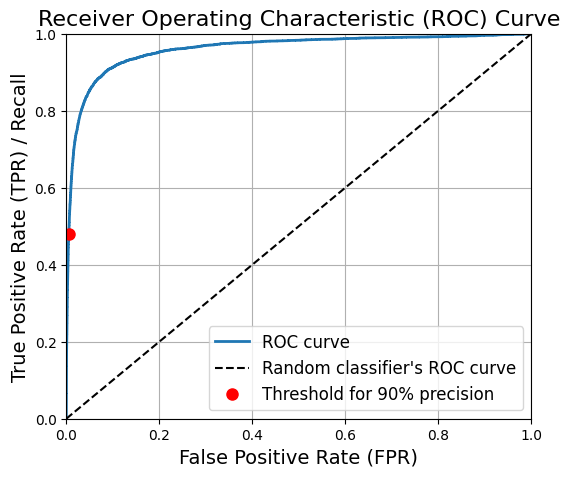

In [37]:
import matplotlib.pyplot as plt

# Assuming you have already defined 'fpr', 'tpr', 'thresholds', 'threshold_for_90_precision'

# Create a figure and axis
fig, ax = plt.subplots(figsize=(6, 5))

# Plot the ROC curve
plt.plot(fpr, tpr, linewidth=2, label="ROC curve")

# Plot the diagonal line representing the ROC curve of a random classifier
plt.plot([0, 1], [0, 1], 'k--', label="Random classifier's ROC curve")

# Highlight the point at the threshold for 90% precision
idx_for_threshold_at_90 = (thresholds <= threshold_for_90_precision).argmax()
tpr_90, fpr_90 = tpr[idx_for_threshold_at_90], fpr[idx_for_threshold_at_90]
plt.plot(fpr_90, tpr_90, "ro", markersize=8, label="Threshold for 90% precision")

plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)

# Beautify the figure
plt.xlabel("False Positive Rate (FPR)", fontsize=14)
plt.ylabel("True Positive Rate (TPR) / Recall", fontsize=14)
plt.title("Receiver Operating Characteristic (ROC) Curve", fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)

# Show the plot
plt.show()


Once again there is a trade-off: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the area under the curve (AUC). A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5. Scikit-Learn provides a function to estimate the ROC AUC:

In [38]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Since the ROC curve is so similar to the precision/recall (PR) curve, you may wonder how to decide which one to use. As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives. Otherwise, use the ROC curve. For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to the negatives (non-5s). In contrast, the PR curve makes it clear that the classifier has room for improvement: the curve could really be closer to the top-right corner.

Let’s now create a RandomForestClassifier, whose PR curve and F1 score we can compare to those of the SGDClassifier:

In [39]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)

The precision_recall_curve() function expects labels and scores for each instance, so we need to train the random forest classifier and make it assign a score to each instance. But the RandomForestClassifier class does not have a decision_function() method, due to the way it works. Luckily, it has a predict_proba() method that returns class probabilities for each instance, and we can just use the probability of the positive class as a score, so it will work fine. We can call the cross_val_predict() function to train the Random ForestClassifier using cross-validation and make it predict class probabilities for every image as follows:

In [40]:
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, 
                                    method='predict_proba')

Let’s look at the class probabilities for the first two images in the training set:

In [41]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

The model predicts that the first image is positive with 89% probability, and it predicts that the second image is negative with 99% probability. Since each image is either positive or negative, the probabilities in each row add up to 100%.'

The second column contains the estimated probabilities for the positive class, so let’s pass them to the precision_recall_curve() function:

In [42]:
y_scores_forest = y_probas_forest[:, 1]
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(
    y_train_5, y_scores_forest)

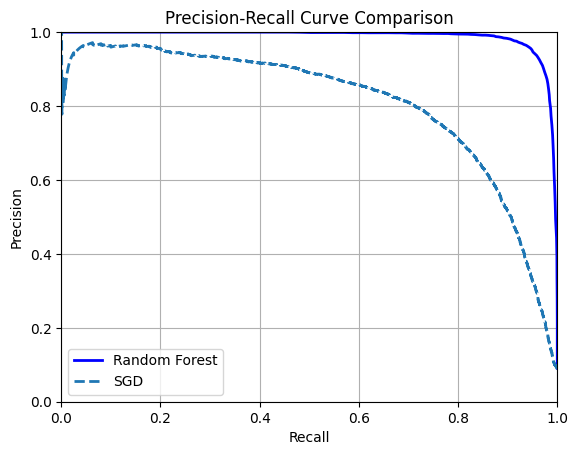

In [43]:
# Plotting Random Forest precision-recall curve in blue solid line
plt.plot(recalls_forest, precisions_forest, "b-", linewidth=2, label="Random Forest")

# Plotting SGD precision-recall curve in dashed line
plt.plot(recalls, precisions, "--", linewidth=2, label="SGD")

# Adding labels and title
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve Comparison")
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.grid(True)

# Adding legend to differentiate between curves
plt.legend()

# Displaying the plot
plt.show()


Comparing PR curves: the random forest classifier is superior to the SGD classifier because its PR curve is much closer to the top-right corner, and it has a greater AUC.

In [44]:
y_train_pred_forest = y_probas_forest[:, 1] >= 0.5 # positive proba ≥ 50%
f1_score(y_train_5, y_train_pred_forest)

0.9274509803921569

In [45]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

## Multiclass Classification

Whereas binary classifiers distinguish between two classes, multiclass classifiers (also called multinomial classifiers) can distinguish between more than two classes.

Some Scikit-Learn classifiers (e.g., LogisticRegression, RandomForestClassifier, and GaussianNB) are capable of handling multiple classes natively. Others are strictly binary classifiers (e.g., SGDClassifier and SVC). However, there are various strategies that you can use to perform multiclass classification with multiple binary classifiers.

One way to create a system that can classify the digit images into 10 classes (from 0 to 9) is to train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you select the class whose classifier outputs the highest score. This is called the one-versus-the-rest (OvR) strategy, or sometimes one-versus-all (OvA).

Another strategy is to train a binary classifier for every pair of digits: one to distin‐ guish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. This is called the one-versus-one (OvO) strategy. If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run the image through all 45 classifiers and see which class wins the most duels. The main advantage of OvO is that each classifier only needs to be trained on the part of the training set containing the two classes that it must distinguish.

Some algorithms (such as support vector machine classifiers) scale poorly with the size of the training set. For these algorithms OvO is preferred because it is faster to train many classifiers on small training sets than to train few classifiers on large training sets. For most binary classification algorithms, however, OvR is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and it automatically runs OvR or OvO, depending on the algorithm. Let’s try this with a support vector machine classifier using the sklearn.svm.SVC class. We’ll only train on the first 2,000 images, or else it will take a very long time:

In [46]:
from sklearn.svm import SVC 
svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000]) # y_train, not y_train_5

SVC(random_state=42)

That was easy! We trained the SVC using the original target classes from 0 to 9 (y_train), instead of the 5-versus-the-rest target classes (y_train_5). Since there are 10 classes (i.e., more than 2), Scikit-Learn used the OvO strategy and trained 45 binary classifiers. Now let’s make a prediction on an image:

In [47]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

That’s correct! This code actually made 45 predictions—one per pair of classes—and it selected the class that won the most duels. If you call the decision_function() method, you will see that it returns 10 scores per instance: one per class. Each class gets a score equal to the number of won duels plus or minus a small tweak (max ±0.33) to break ties, based on the classifier scores:

In [50]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

The highest score is 9.3, and it’s indeed the one corresponding to class 5:

In [51]:
class_id = some_digit_scores.argmax()  
class_id

5

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In the case of MNIST, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class '5'), but in general you won’t be so lucky; you will need to look up the class label like this:

In [52]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [53]:
svm_clf.classes_[class_id]

'5'

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-rest, you can use the OneVsOneClassifier or OneVsRestClassifier classes. Simply create an instance and pass a classifier to its constructor (it doesn’t even have to be a binary classifier). For example, this code creates a multiclass classifier using the OvR strategy, based on an SVC:

In [54]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [55]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [56]:
len(ovr_clf.estimators_)

10